#Импорт библитек и данных

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

from google.colab import drive

In [251]:
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Karmanova/data sets/test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [252]:
data

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
0,53608,32,management,single,tertiary,no,12569,no,no,cellular,1,jul,2,295,2,success
1,51055,25,services,single,secondary,no,801,no,no,cellular,5,jun,2,-1,0,unknown
2,52573,46,blue-collar,married,secondary,no,1728,yes,no,unknown,26,may,2,-1,0,unknown
3,50458,39,management,divorced,secondary,no,51,no,no,unknown,17,jun,2,-1,0,unknown
4,52272,31,services,single,tertiary,no,1626,no,no,unknown,31,jul,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4286,50332,47,admin.,married,secondary,no,520,no,no,telephone,9,feb,6,-1,0,unknown
4287,51293,33,technician,married,secondary,no,133,no,no,cellular,12,nov,2,192,1,success
4288,54023,40,admin.,married,secondary,no,2574,yes,no,cellular,20,nov,1,-1,0,unknown
4289,53775,39,blue-collar,married,secondary,no,2467,no,no,cellular,19,jul,2,276,3,other


## Обработка данных

In [253]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

marital_mapping = {'single': 0, 'divorced': 1, 'married': 2}
data['marital'] = data ['marital'].map(marital_mapping)

In [254]:
data

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
0,1.181072,-0.788454,management,0,tertiary,no,3.557711,no,no,cellular,-1.777919,jul,-0.215257,2.390623,0.637286,success
1,-0.879951,-1.407257,services,0,secondary,no,-0.215830,no,no,cellular,-1.298089,jun,-0.215257,-0.454869,-0.350289,unknown
2,0.345522,0.449150,blue-collar,2,secondary,no,0.081423,yes,no,unknown,1.221016,may,-0.215257,-0.454869,-0.350289,unknown
3,-1.361906,-0.169652,management,1,secondary,no,-0.456326,no,no,unknown,0.141399,jun,-0.215257,-0.454869,-0.350289,unknown
4,0.102526,-0.876855,services,0,tertiary,no,0.048715,no,no,unknown,1.820803,jul,-0.566997,-0.454869,-0.350289,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4286,-1.463625,0.537551,admin.,2,secondary,no,-0.305936,no,no,telephone,-0.818260,feb,1.191701,-0.454869,-0.350289,unknown
4287,-0.687815,-0.700054,technician,2,secondary,no,-0.430032,no,no,cellular,-0.458388,nov,-0.215257,1.400469,0.143499,success
4288,1.516100,-0.081252,admin.,2,secondary,no,0.352702,yes,no,cellular,0.501271,nov,-0.566997,-0.454869,-0.350289,unknown
4289,1.315890,-0.169652,blue-collar,2,secondary,no,0.318391,no,no,cellular,0.381314,jul,-0.215257,2.207973,1.131074,other


## Функция подсчёта метрик

In [255]:
def get_metrics(model, X_test, y_test, average='macro'):
  y_pred = model.predict(X_test)
  metrics = {
      "accuracy": accuracy_score(y_test, y_pred),
      "precision": precision_score(y_test, y_pred, average=average),
      "recall": recall_score(y_test, y_pred, average=average),
      "f1_score": f1_score(y_test, y_pred, average=average),
  }
  return metrics

#Задаём признаки и таргет

In [256]:
X = data.drop("marital", axis=1)
y = data["marital"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Преобразуем категориальные значения

In [257]:
categorical_cols = X.select_dtypes(include=["object"]).columns
transformer = ColumnTransformer(
    transformers=[("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols)],
    remainder="passthrough",
)

In [258]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [259]:
X_train.shape

(3432, 48)

# Задаём классы моделей

In [260]:
class SVCModel:
    def __init__(self, kernel='rbf', C=1.0, gamma='auto'):
        self.model = SVC(kernel=kernel, C=C, gamma=gamma)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def tune_hyperparameters(self, X, y, cv=5):
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
                      'gamma': [0.001, 0.01, 0.1, 1]}
        grid_search = GridSearchCV(self.model, param_grid, cv=cv)
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_

class NuSVCModel:
    def __init__(self, nu=0.1, kernel='rbf', gamma='auto'):
        self.model = NuSVC(nu=nu, kernel=kernel, gamma=gamma)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def tune_hyperparameters(self, X, y, cv=5):
        param_grid = {'nu': [0.1, 0.2, 0.3, 0.4, 0.5],
                      'gamma': [0.001, 0.01, 0.1, 1]}
        grid_search = GridSearchCV(self.model, param_grid, cv=cv)
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_

class LinearSVCModel:
    def __init__(self, C=1.0):
        self.model = LinearSVC(C=C)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def tune_hyperparameters(self, X, y, cv=5):
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        grid_search = GridSearchCV(self.model, param_grid, cv=cv)
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_

## Функция выбора K

In [261]:
def select_best_features(X, y, k):
    selector = SelectKBest(f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    return X_selected

## Функция отрисовки графиков сравнения

In [262]:
def plot_all_metrics(models_metrics):
    fig, ax = plt.subplots(figsize=(6, 5))
    colors = ['lightblue', 'lightgreen', 'pink']

    for i, (model_name, metrics) in enumerate(models_metrics.items()):
        x = np.arange(len(metrics))
        ax.bar(x=x,
              height=metrics.values(),
              label=model_name,
              color=colors[i])
    ax.set_xlabel('Метрика')
    ax.set_ylabel('Значение')
    ax.set_title('Сравнение метрик моделей')
    ax.legend(bbox_to_anchor=(1, 0.05), loc='lower right')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics.keys(), rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

# Обучаем модель №1 - **SVC mod1l**

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


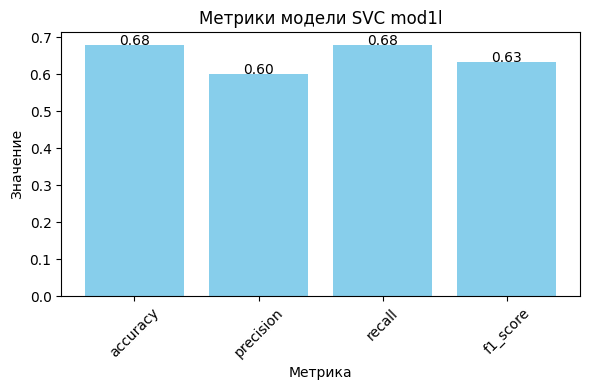

In [263]:
X_train1 = select_best_features(X_train, y_train, 48)

mod1l = SVCModel()
mod1l.fit(X_train1, y_train)
mod1l_metrics = get_metrics(mod1l, X_test, y_test, average='weighted')
plot_metrics(mod1l_metrics, 'SVC mod1l')

# Обучаем модель №2 - **NuSVC mod2l**



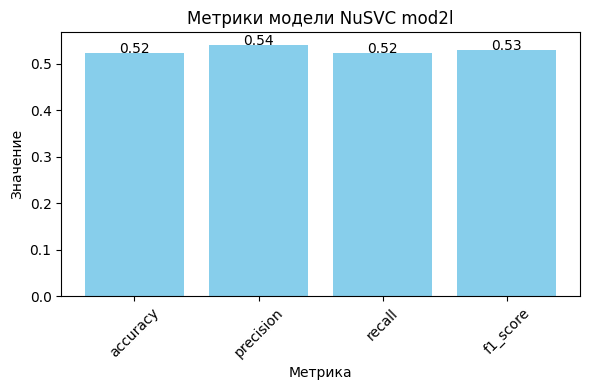

In [264]:
X_train2 = select_best_features(X_train, y_train, 48)

mod2l = NuSVCModel()
mod2l.fit(X_train2, y_train)
mod2l_metrics = get_metrics(mod2l, X_test, y_test, average='weighted')
plot_metrics(mod2l_metrics, 'NuSVC mod2l')

# Обучаем модель №3 - **LinearSVC mod3l**

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


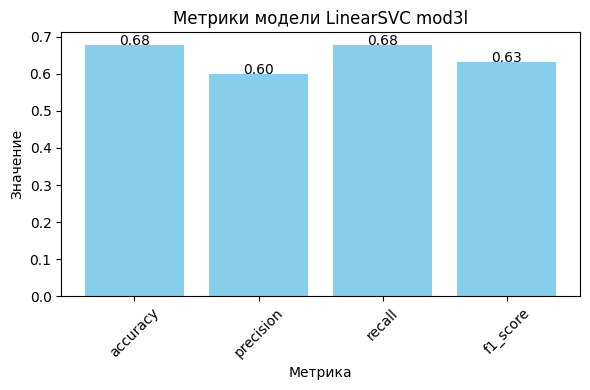

In [265]:
X_train3 = select_best_features(X_train, y_train, 48)

mod3l = LinearSVCModel()
mod3l.fit(X_train3, y_train)
mod3l_metrics = get_metrics(mod3l, X_test, y_test, average='weighted')
plot_metrics(mod3l_metrics, 'LinearSVC mod3l')

# Визуализируем и сравниваем все метрики

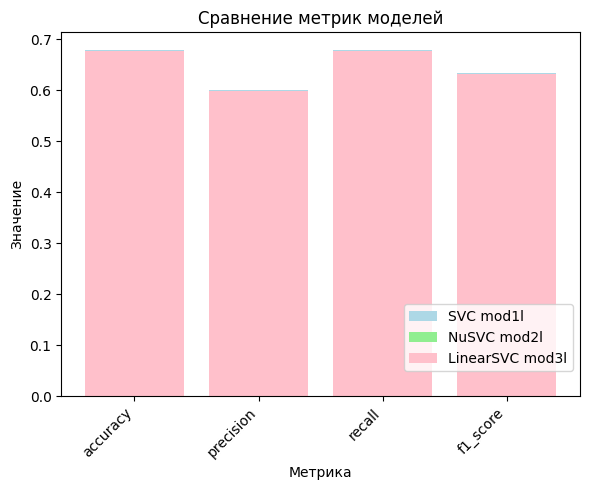

In [266]:
all_models_metrics = {
    'SVC mod1l': mod1l_metrics,
    'NuSVC mod2l': mod2l_metrics,
    'LinearSVC mod3l': mod3l_metrics,
}

plot_all_metrics(all_models_metrics)